# DATASET WITH 'covid_year_timeline'

Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [2]:
RANDOM_STATE = 42

df, column_trans, idx, df_orig = pp.preprocessData()

Split the dataset in X and y.

In [3]:
X = df.drop(columns=['log_scaled__total_sale_price'])
y = df['log_scaled__total_sale_price']

Showing how the original dataset is preprocessed and transformed.

In [4]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate', 'covid_cases',
                                  'lumber_price', 'metals_price', 'build_price',
                                  'supply', 'crime',
                                  'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate',
                                  'pop_growth_rate', 'int_rate', 'demand',
                                  'year']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

Showing the index of the columns in the dataframe based on preprocess methods.

In [5]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 54, None),
 'mm_scaled': slice(54, 56, None),
 'std_scale': slice(56, 62, None),
 'passthru': slice(62, 69, None),
 'remainder': slice(0, 0, None)}

# K-Means Clustering

We perform a Kmeans Clustering with the transformed dataset.

### Elbow Method

The k-means algorithm tries to minimize distortion, which is defined as the sum of the squared distances between each observation vector and its dominating centroid. Each step of the k-means algorithm refines the choices of centroids to reduce distortion.

The below we see the elbow point as # of clusters reference. We have to be careful using this because it is less releveant when the elbow point is not obvious.
As seen below, the elbow point is not very obvious. So we move to check with Silhouette Score.

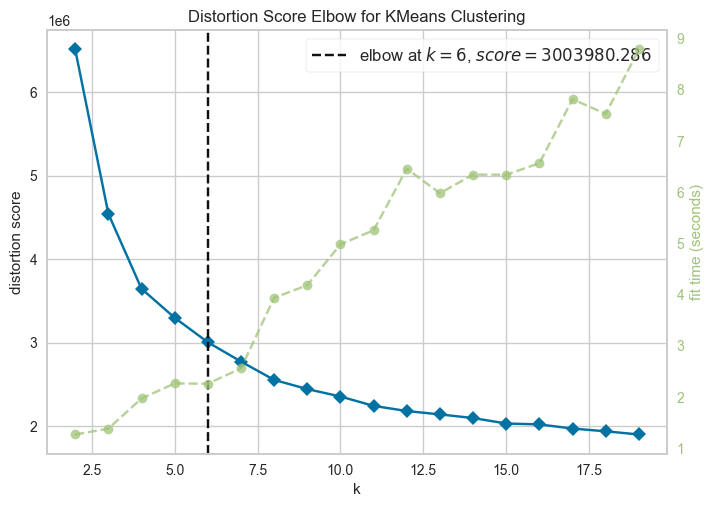

In [4]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)
k_start = 2
k_end = 20

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(k_start, k_end)).fit(X).show()  

### Silhouette Score & Inertia

This score shows the goodness of the clusters. The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

c:\Users\choit\OneDrive\Coursera\SIADS696\Project2\SIADS-696-Milestone-II\Viz.py:263: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



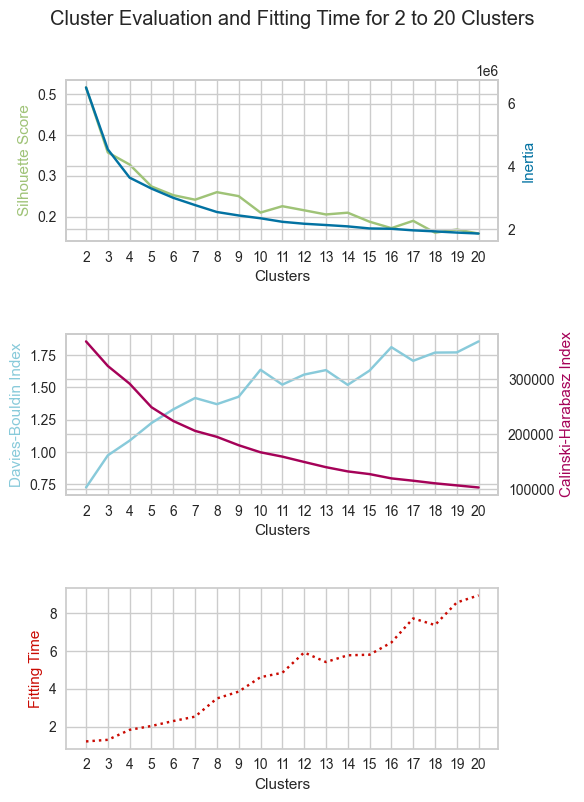

In [4]:
viz.plot_silhouette(X, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

No agreement on clusters found based on silhouette scores and inertia, so we visualize Silhouette plot for 5, 6, 7 clusters because they happened to be at the crossing point on DB Index and CH Index and Elbow Method recommended 6 clusters.

We can see that they even though clusters are forming, we have relatively low silhouette scores, we also cannot decide to which 2 features to use on the axis to view the clusters properly. 
The cluster centers are all located at the same spots as seen on the scatterplot below.

For n_clusters = 5 The average silhouette_score is : 0.27155629379517227
For n_clusters = 6 The average silhouette_score is : 0.26174570751826276
For n_clusters = 7 The average silhouette_score is : 0.2440452687628937


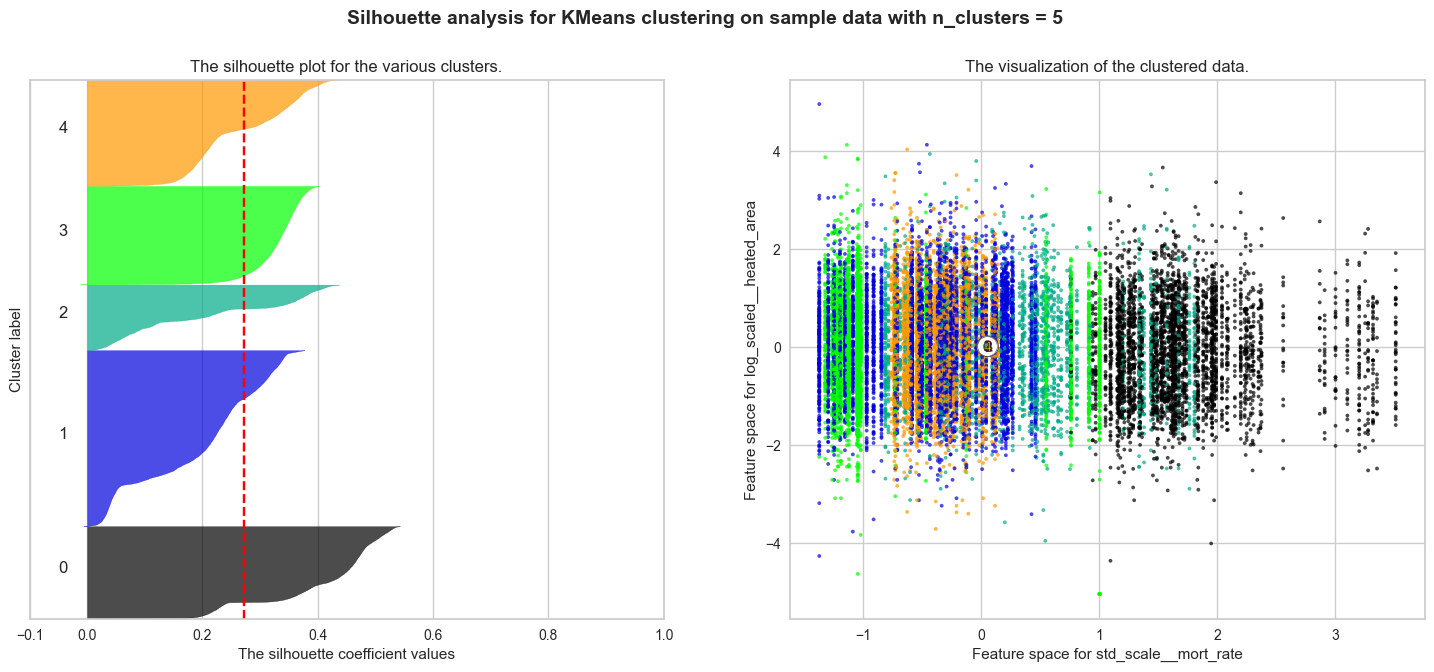

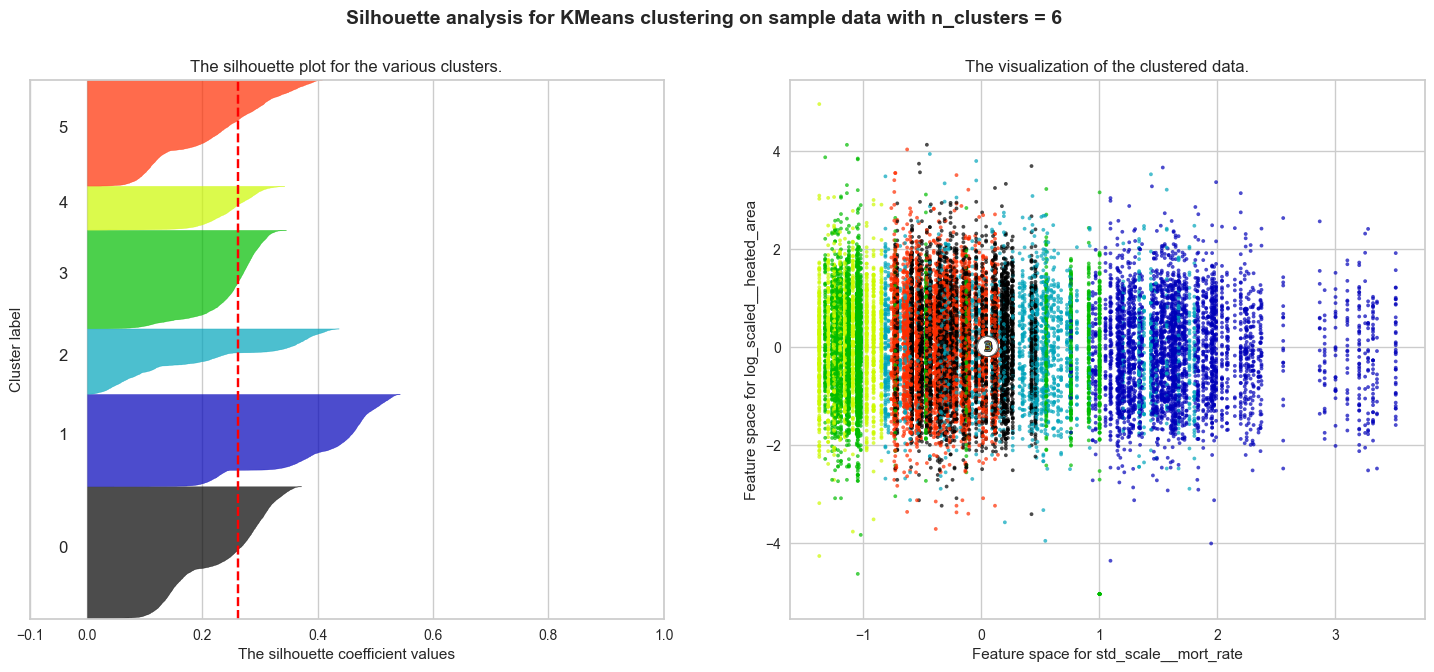

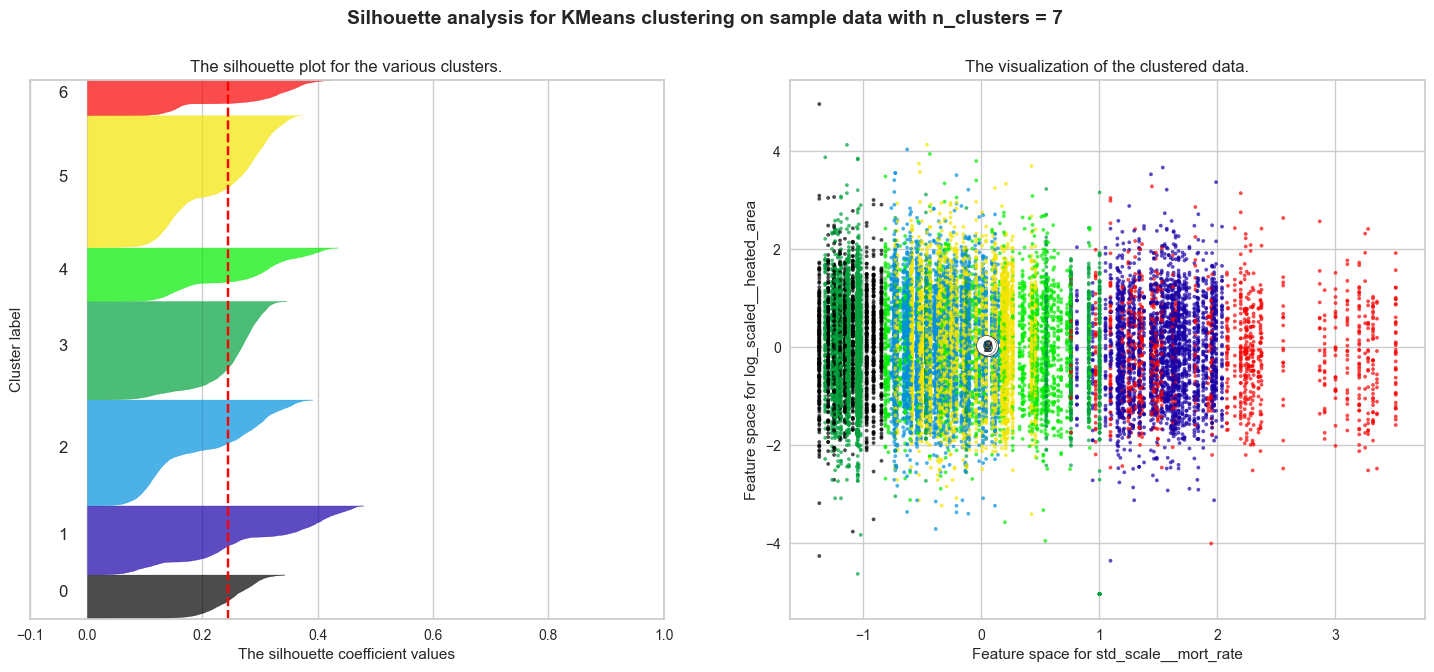

In [9]:
range_n_clusters = [5, 6, 7]
ax = 'std_scale__mort_rate'
ay = 'log_scaled__heated_area'

viz.draw_silhouette(X, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

# PCA

PCA allows to project the data from the original 68-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space. - sklearn

In [5]:
# initiate PCA model

pca = PCA(n_components=None, random_state=RANDOM_STATE)
pca.fit(X)


PCA(random_state=42)

Scree Plot helps us to visually decide how many PC to use. In practice, we take PCs with cumulative explained variance between 70% to 90%

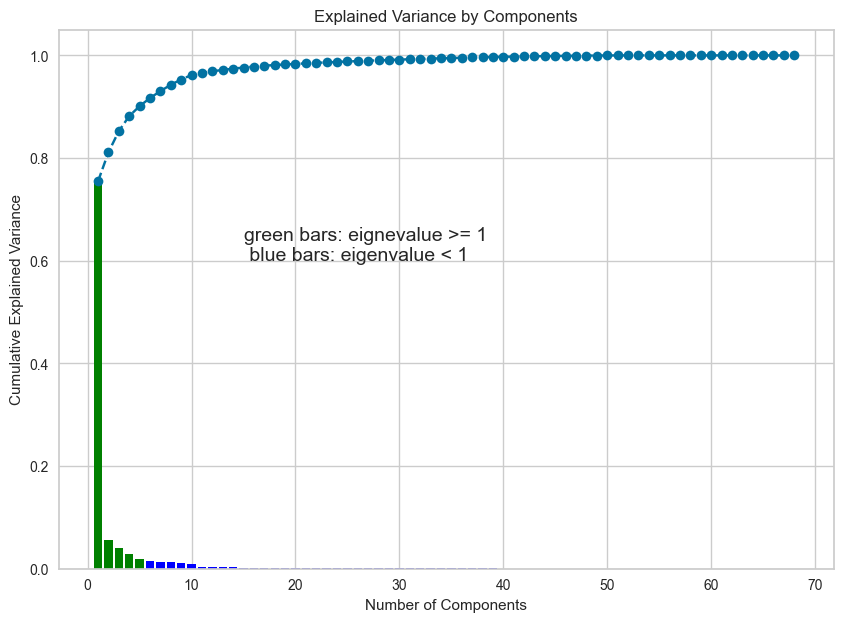

In [6]:
# make PCA scree plot

viz.make_PCA_screeplot(pca)

The eigenvalues (variance explained by each PC) for PCs can help to retain the number of PCs. According to Kaiser’s rule, PCs with eigenvalues > 1 contributes greater variance and should be retained for further analysis. 

In [6]:
cum_explained = 0
pc_ct = 0

for i, val in enumerate(pca.explained_variance_):
    if val >= 1:
        cum_explained = cum_explained + pca.explained_variance_ratio_[i]
        pc_ct += 1 
        print('PC'+str(i+1)+' explained variance ratio is '+str(pca.explained_variance_ratio_[i]))

print('Cumulative explained variance ratio for the '+str(pc_ct)+' PCs with eigenvalues >= 1 is '+str(cum_explained))


PC1 explained variance ratio is 0.7547454986706483
PC2 explained variance ratio is 0.05644689919496667
PC3 explained variance ratio is 0.04130089405540872
PC4 explained variance ratio is 0.029237621587786273
PC5 explained variance ratio is 0.019380625066397737
Cumulative explained variance ratio for the 5 PCs with eigenvalues >= 1 is 0.9011115385752078


PCA with selected # of components

In [7]:
n = 5
pca_n = PCA(n_components=n, random_state=RANDOM_STATE)
pca_n_out_matrix = pca_n.fit_transform(X)

Top 10 features for each selected PC

In [8]:
viz.top_PC_loadings(pca_n, feature_names=X.columns.values, top_n=10)

,PC1 Top Feature,PC1 Loadings (ratio=0.755),PC2 Top Feature,PC2 Loadings (ratio=0.056),PC3 Top Feature,PC3 Loadings (ratio=0.041),PC4 Top Feature,PC4 Loadings (ratio=0.029),PC5 Top Feature,PC5 Loadings (ratio=0.019)
0,std_scale__mort_rate,0.1281,log_scaled__supply,0.4582,log_scaled__crime,0.1065,log_scaled__covid_cases,0.3801,std_scale__story_height,0.5978
1,std_scale__pop_growth_rate,0.1047,log_scaled__lumber_price,0.2967,onehot__physical_city_raleigh,0.0802,log_scaled__unemploy_rate,0.3487,log_scaled__heated_area,0.3320
2,std_scale__int_rate,0.0781,log_scaled__covid_cases,0.2754,onehot__physical_zip_code_27610,0.0347,log_scaled__metals_price,0.2708,mm_scaled__bath,0.0392
3,log_scaled__crime,0.0661,std_scale__mort_rate,0.2259,passthru__covid_year_timeline,0.0299,log_scaled__lumber_price,0.2193,onehot__physical_city_wake forest,0.0148
4,log_scaled__unemploy_rate,0.0371,std_scale__pop_growth_rate,0.2230,std_scale__demand,0.0269,log_scaled__build_price,0.1829,onehot__physical_zip_code_27587,0.0148
5,log_scaled__supply,0.0314,log_scaled__build_price,0.2079,log_scaled__unemploy_rate,0.0228,passthru__is_covid,0.1632,std_scale__int_rate,0.0138
6,onehot__physical_city_raleigh,0.0056,log_scaled__metals_price,0.1365,onehot__physical_zip_code_27604,0.0189,std_scale__demand,0.0778,onehot__physical_zip_code_27616,0.0120
7,passthru__water,0.0022,std_scale__int_rate,0.1177,passthru__sewer,0.0181,onehot__physical_zip_code_27587,0.0214,passthru__all,0.0101
8,onehot__physical_city_cary,0.0016,passthru__is_covid,0.1020,passthru__water,0.0149,onehot__physical_city_wake forest,0.0214,onehot__physical_zip_code_27610,0.0097
9,passthru__sewer,0.0014,onehot__physical_city_fuquay varina,0.0061,onehot__physical_zip_code_27616,0.0124,onehot__physical_city_fuquay varina,0.0186,passthru__gas,0.0096


Full feature loadings Heatmap

Loadings heatmap image saved in folder
Shape before PCA:  (275848, 68)
Shape after PCA:  (275848, 5)


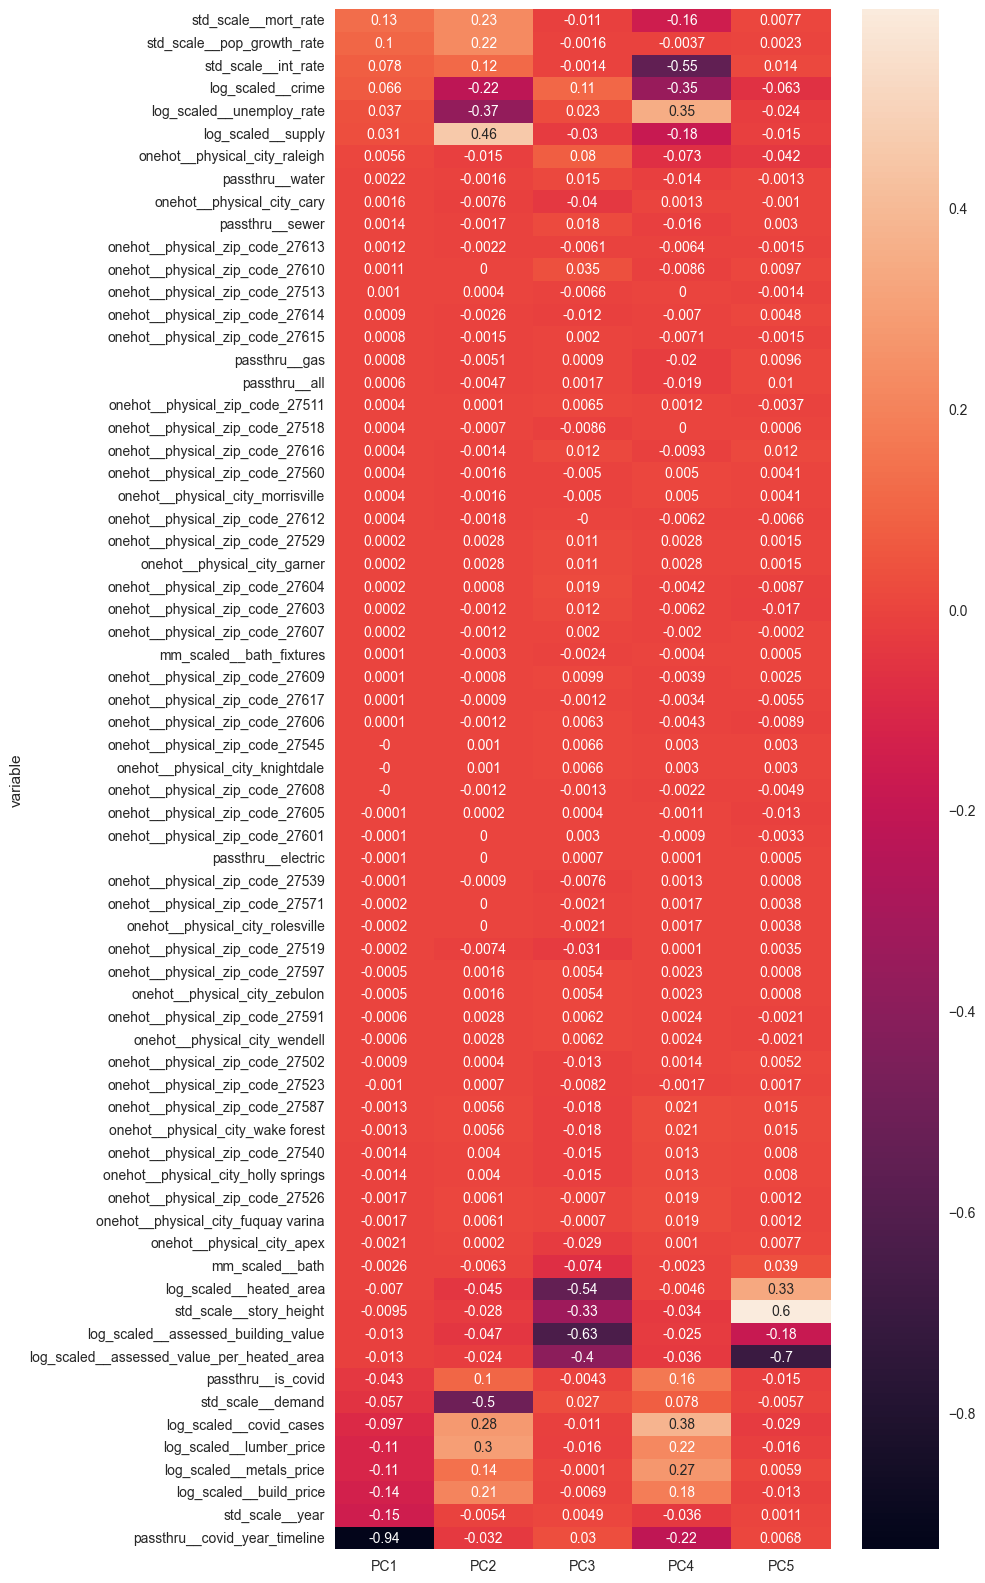

In [9]:
loadings_df = viz.make_loadings_df(pca_n, feature_names=X.columns.values)

plt.figure(figsize=(8,20))
sns.heatmap(loadings_df, annot=True, annot_kws={"size": 10})
plt.savefig('pca_n_component_loadings_heatmap_withTL.png')
print('Loadings heatmap image saved in folder')

print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_n_out_matrix.shape)

In [10]:
# change the pca-transformed matrix to df

pca_n_df = pd.DataFrame(pca_n_out_matrix, columns=['PC'+str(i) for i in range(1, pca_n.n_components_+1)])

# Kmeans with PCA Feature Space

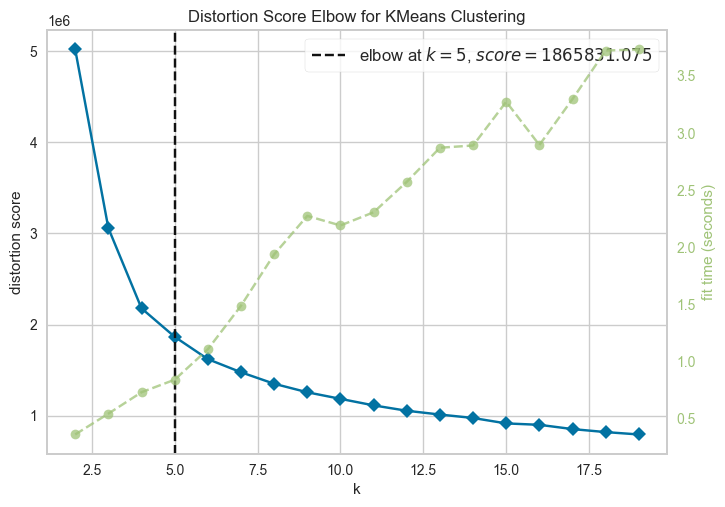

In [11]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(pca_n_out_matrix).show()  

c:\Users\choit\OneDrive\Coursera\SIADS696\Project2\SIADS-696-Milestone-II\Viz.py:263: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



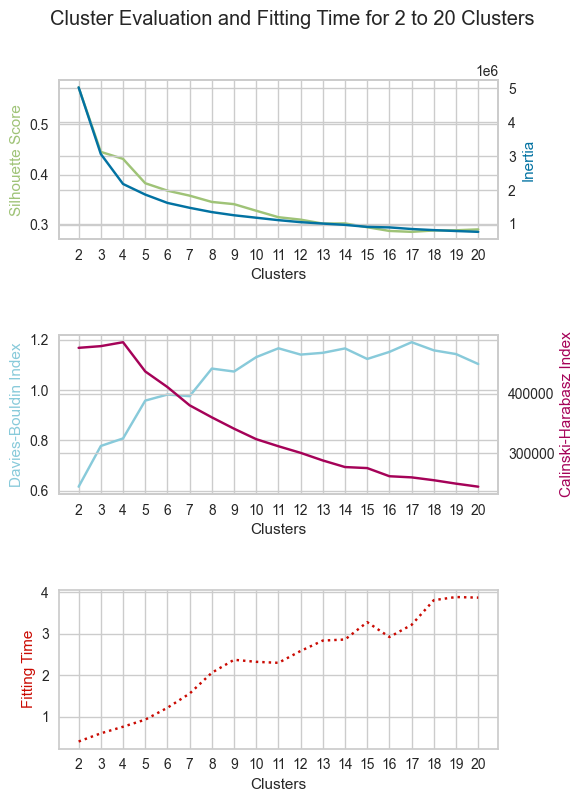

In [12]:
viz.plot_silhouette(pca_n_out_matrix, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

Based on the scores above, let's look at silhouette plots for 3, 4, and 5 clusters.

For n_clusters = 3 The average silhouette_score is : 0.44525025336149593
For n_clusters = 4 The average silhouette_score is : 0.4311495301031737
For n_clusters = 5 The average silhouette_score is : 0.38284851684471505


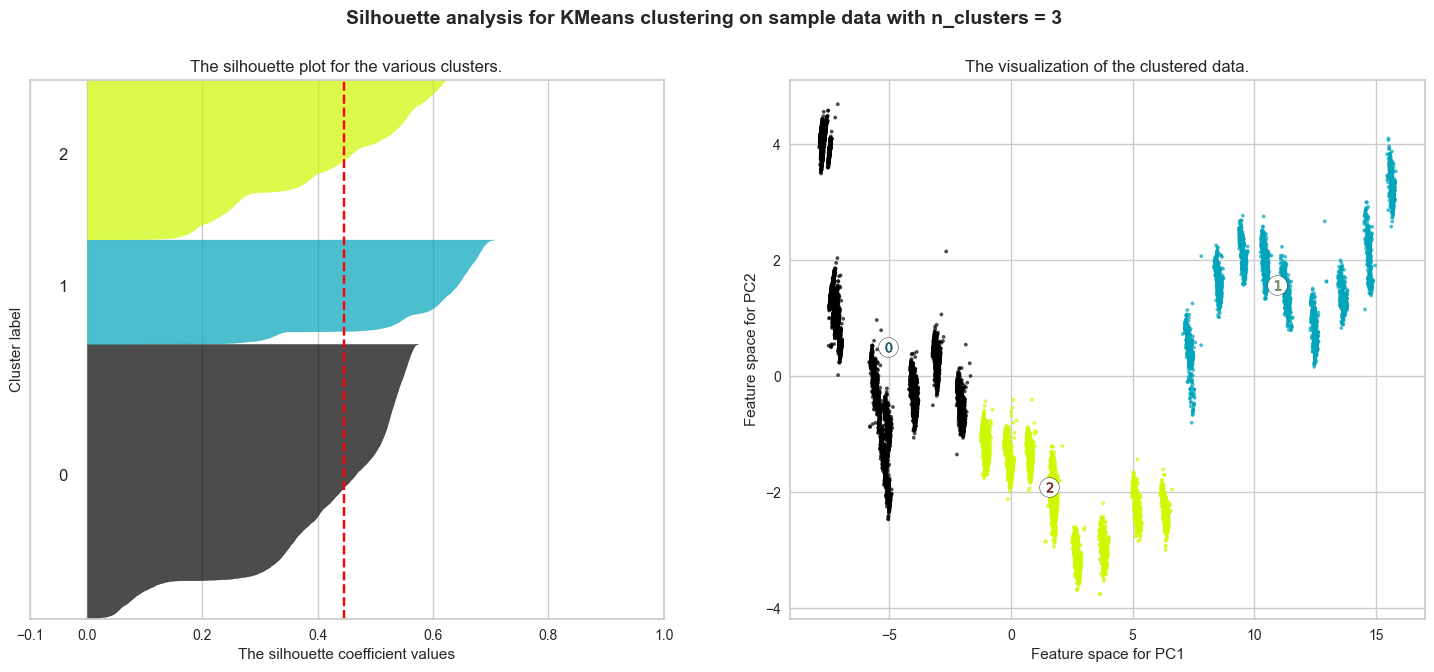

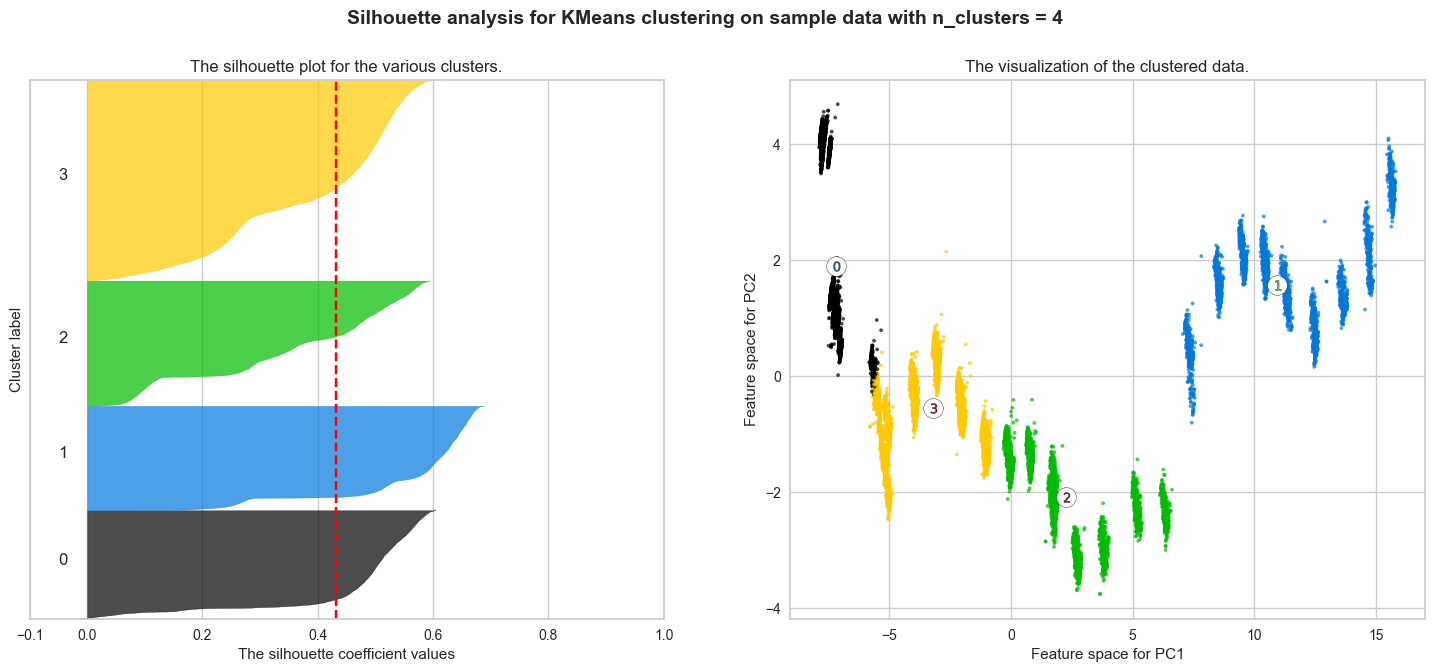

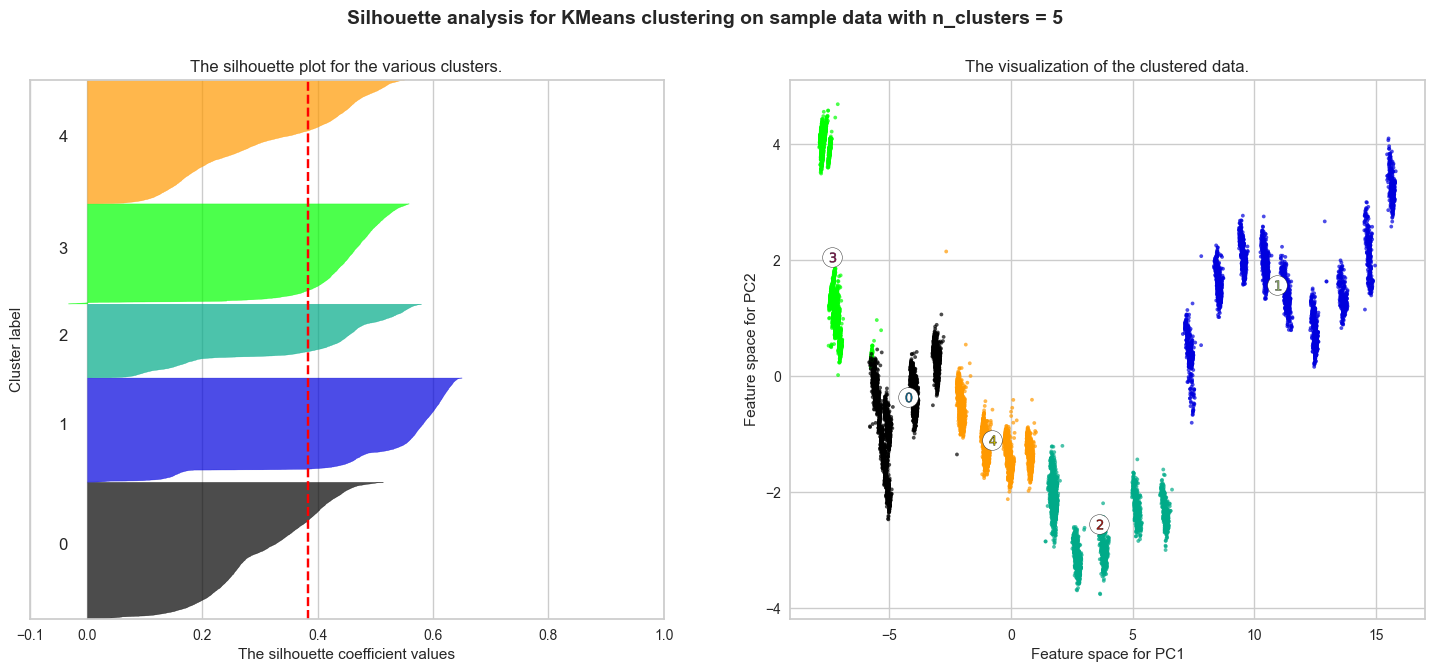

In [13]:
range_n_clusters = [3, 4, 5]
ax = 'PC1'
ay = 'PC2'

viz.draw_silhouette(pca_n_df, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

Final Decision: 4 clusters. 

We construct the full df for original preprocessing features, PC features, and cluster labels

In [15]:
#decided # of clusters
final_k = 4

#K-means clustering with PCA results
kmeans = KMeans(init='k-means++', n_clusters=final_k, random_state=RANDOM_STATE)
kmeans.fit_transform(X)

# create a new DF with original features and add PCA scores and assigned clusters
pca_kmeans_df = pd.concat([X.reset_index(drop=True), pd.DataFrame(pca_n_out_matrix)], axis =1)
pca_kmeans_df.columns.values[-n:] = ['PC'+str(i) for i in range(1, pca_n.n_components_+1)]

# add the last column with the clustering labels
pca_kmeans_df['ClusterLabels'] = kmeans.labels_

pca_kmeans_df.head()

,onehot__physical_zip_code_27502,onehot__physical_zip_code_27511,onehot__physical_zip_code_27513,onehot__physical_zip_code_27518,onehot__physical_zip_code_27519,onehot__physical_zip_code_27523,onehot__physical_zip_code_27526,onehot__physical_zip_code_27529,onehot__physical_zip_code_27539,onehot__physical_zip_code_27540,...,passthru__sewer,passthru__all,passthru__is_covid,passthru__covid_year_timeline,PC1,PC2,PC3,PC4,PC5,ClusterLabels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-20.0,15.684734,3.218590,0.167261,-1.963854,0.487466,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-20.0,15.731804,3.347105,1.894991,-1.834039,0.011961,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-20.0,15.628590,3.500024,0.397105,-1.426466,-0.489606,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-20.0,15.750366,3.430801,2.979400,-1.804355,-0.067524,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-20.0,15.767189,3.386514,2.714421,-1.721143,2.490237,1


### K-means clustering with PCA results

In [16]:
# Biplot - same thing as above but now with PC and loadings
loadings = pca_n.components_.T * np.sqrt(pca_n.explained_variance_)
features = X.columns.to_list()
color = pca_kmeans_df['ClusterLabels'].astype(str)

fig = px.scatter(
    pca_n_out_matrix, x=0, y=1, color=color,
    color_discrete_sequence=px.colors.qualitative.Set2,
    #color_continuous_scale=px.colors.sequential.Purpor #px.colors.diverging.Sunset
)
fig.update_traces(marker_size = 2)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
        )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        )

fig.write_html("pca_biplot_with_covid_timeline_withTL.html")
#fig.show()